In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers, constraints
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler

Data Preparation

In [47]:
# scalers
mr_scaler = joblib.load("scalers/mr_scaler.pkl")
p_scaler = joblib.load("scalers/p_scaler.pkl")
rho_scaler = MinMaxScaler(feature_range=(0, 0.1))

In [48]:
# this is our "observed" mr relation
observed_mr = pd.read_csv("dataframes/sample_mr.csv").query("ID == 15033").sort_values("M")

# define target masses between 1.0 and 2.25 M⊙
m_targets = np.linspace(1, 2.25, 11)

# for each target mass, pick the closest real row
observed_mr = observed_mr.iloc[np.abs(observed_mr["M"].values[:, None] - m_targets).argmin(axis=0)]
observed_mr = observed_mr.reset_index(drop=True)

MR_obs_np = np.column_stack((observed_mr["M"].values, observed_mr["R"].values))

# Scale both together
MR_obs_scaled = mr_scaler.transform(MR_obs_np)

# Split them back if needed
M_obs = tf.constant(MR_obs_scaled[:, 0], dtype=tf.float32)
R_obs = tf.constant(MR_obs_scaled[:, 1], dtype=tf.float32)

delta = mr_scaler.transform(np.array([[1.0, 1.0]]))
dM = tf.constant([delta[0][0]] * len(M_obs), dtype=tf.float32)
dR = tf.constant([delta[0][1]] * len(R_obs), dtype=tf.float32)

In [49]:
true_eos = pd.read_csv("dataframes/sample_eos.csv").query("ID == 15033").sort_values("rho")
true_eos['rho'] = true_eos['rho'] / 0.16
data = true_eos.sort_values('rho').reset_index(drop=True)

density_filter = np.linspace(1, 7.4, 32)

chosen = []
df_temp = data.copy()
for t in density_filter :
    proposed_idx = (df_temp['rho'] - t).abs().idxmin()
    chosen.append(proposed_idx)
    df_temp = df_temp.drop(proposed_idx)
resampled = data.iloc[chosen].reset_index(drop=True)
resampled.index = range(len(resampled))

data = resampled.copy(deep=True)

EOS Network

In [50]:
def build_eos_network(input_length=32, input_channels=1, output_channels=1):
    """
    Builds the EoS Network as described:
    - 3 Conv1D layers (kernel size = 1)
    - 2 hidden layers (64 filters each)
    - He normal initialization
    - L2 regularization (λ = 1e-8)
    - Same padding
    - NON-NEGATIVE WEIGHTS constraint
    """

    inputs = layers.Input(shape=(input_length, input_channels))

    x = layers.Conv1D(
        filters=64,
        kernel_size=1,
        padding="same",
        activation="elu",           
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(1e-8),
        kernel_constraint=constraints.NonNeg(),
        bias_constraint=constraints.NonNeg()
    )(inputs)

    x = layers.Conv1D(
        filters=64,
        kernel_size=1,
        padding="same",
        activation="elu",
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(1e-8),
        kernel_constraint=constraints.NonNeg(),
        bias_constraint=constraints.NonNeg()
    )(x)
    
    # Output layer
    outputs = layers.Conv1D(
        filters=output_channels,
        kernel_size=1,
        padding="same",
        activation="tanh",
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(1e-8),
        kernel_constraint=constraints.NonNeg(),
        bias_constraint=constraints.NonNeg()
    )(x)

    model = models.Model(inputs, outputs, name="EoS_Network")

    return model

In [51]:
tov_solver = load_model("models/tov_solver.h5", compile=False)
tov_solver.trainable = False            


# density -> pressure -> (M,R)
model = build_eos_network()
rho_input = tf.keras.Input(shape=(32,1), name='density_input')
pred_pressure = model(rho_input)
pred_mr = tov_solver(pred_pressure)   # frozen network
combined_model = tf.keras.Model(inputs=rho_input, outputs=pred_mr)

In [52]:
def chi2_loss(M_obs, R_obs, dM, dR, tau=1):
    def loss(y_true, y_pred):
        # y_pred: (1, N_rho, 2)
        mr_seq = tf.squeeze(y_pred, axis=0)
        M_seq, R_seq = mr_seq[:, 0], mr_seq[:, 1]

        # Weighted squared distance matrix (Eq. 4.2)
        d2 = (
            tf.square((M_seq[None, :] - M_obs[:, None]) / dM[:, None]) +
            tf.square((R_seq[None, :] - R_obs[:, None]) / dR[:, None])
        )

        # ---- Soft argmin weights ----
        w = tf.nn.softmax(-d2 / tau, axis=1)  # (N_obs, N_rho)
        # (closer points → higher weights)

        # ---- Differentiable weighted match ----
        M_match = tf.reduce_sum(w * M_seq[None, :], axis=1)
        R_match = tf.reduce_sum(w * R_seq[None, :], axis=1)

        # ---- χ² loss ----
        chi2 = tf.reduce_sum(
            tf.square((M_match - M_obs) / dM) +
            tf.square((R_match - R_obs) / dR)
        )
        
        return chi2
    return loss

In [53]:
loss_fn = chi2_loss(M_obs, R_obs, dM, dR)

def lr_schedule(epoch):
    if epoch < 100:
        return 0.01
    elif epoch < 200:
        return 0.05
    elif epoch < 350:
        return 0.03
    elif epoch < 510:
        return 0.001
    else:
        return 0.0003

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

Epoch 1/1000
1/1 - 1s - 1s/step - loss: 28.9659 - learning_rate: 0.0100
Epoch 2/1000
1/1 - 0s - 34ms/step - loss: 4.2545 - learning_rate: 0.0100
Epoch 3/1000
1/1 - 0s - 33ms/step - loss: 0.4633 - learning_rate: 0.0100
Epoch 4/1000
1/1 - 0s - 34ms/step - loss: 0.4289 - learning_rate: 0.0100
Epoch 5/1000
1/1 - 0s - 33ms/step - loss: 0.8209 - learning_rate: 0.0100
Epoch 6/1000
1/1 - 0s - 34ms/step - loss: 1.1092 - learning_rate: 0.0100
Epoch 7/1000
1/1 - 0s - 35ms/step - loss: 1.2855 - learning_rate: 0.0100
Epoch 8/1000
1/1 - 0s - 34ms/step - loss: 1.3875 - learning_rate: 0.0100
Epoch 9/1000
1/1 - 0s - 33ms/step - loss: 1.4392 - learning_rate: 0.0100
Epoch 10/1000
1/1 - 0s - 33ms/step - loss: 1.4559 - learning_rate: 0.0100
Epoch 11/1000
1/1 - 0s - 35ms/step - loss: 1.4449 - learning_rate: 0.0100
Epoch 12/1000
1/1 - 0s - 36ms/step - loss: 1.4101 - learning_rate: 0.0100
Epoch 13/1000
1/1 - 0s - 34ms/step - loss: 1.3525 - learning_rate: 0.0100
Epoch 14/1000
1/1 - 0s - 33ms/step - loss: 1.274

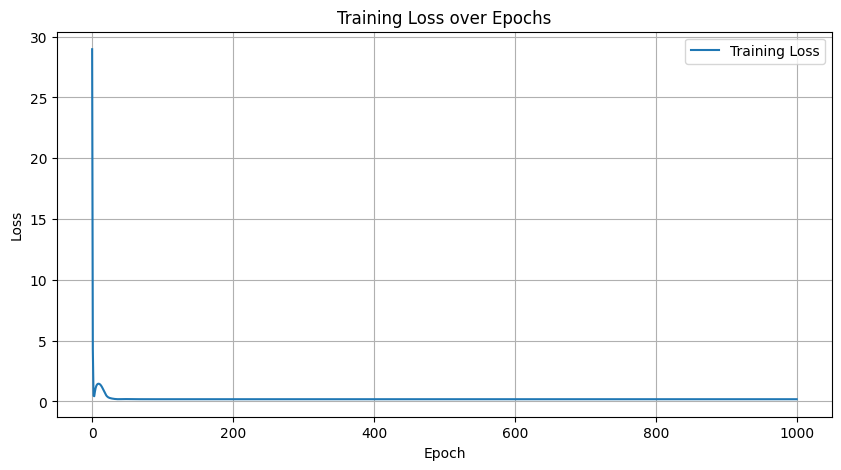

In [54]:
combined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss_fn
)

X = np.zeros((1, 32, 1), dtype=np.float32)
X_scaled = rho_scaler.fit_transform(data['rho'].values.reshape(-1, 1)).reshape(X.shape)

history = combined_model.fit(
    X_scaled,
    np.zeros((len(X_scaled), 2)),  # dummy target
    epochs=1000,
    batch_size=1,
    verbose=2,
    callbacks=[lr_callback]
)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Results

In [55]:
p_pred = model.predict(X_scaled)
p_actual_scaled = p_scaler.transform(np.log10(np.clip(data['p'].values, 1e-30, None)).reshape(-1, 1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [56]:
p_pred

array([[[0.07988384],
        [0.14428025],
        [0.228191  ],
        [0.2890414 ],
        [0.34764242],
        [0.42169   ],
        [0.47382045],
        [0.52282894],
        [0.56860894],
        [0.6245624 ],
        [0.6627437 ],
        [0.6977643 ],
        [0.7397452 ],
        [0.7678861 ],
        [0.7933458 ],
        [0.82343113],
        [0.843338  ],
        [0.8611715 ],
        [0.87711024],
        [0.8957101 ],
        [0.90787977],
        [0.91869026],
        [0.9312273 ],
        [0.93938506],
        [0.9466018 ],
        [0.9549363 ],
        [0.9603395 ],
        [0.9651063 ],
        [0.96930915],
        [0.9741465 ],
        [0.9772731 ],
        [0.9800253 ]]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


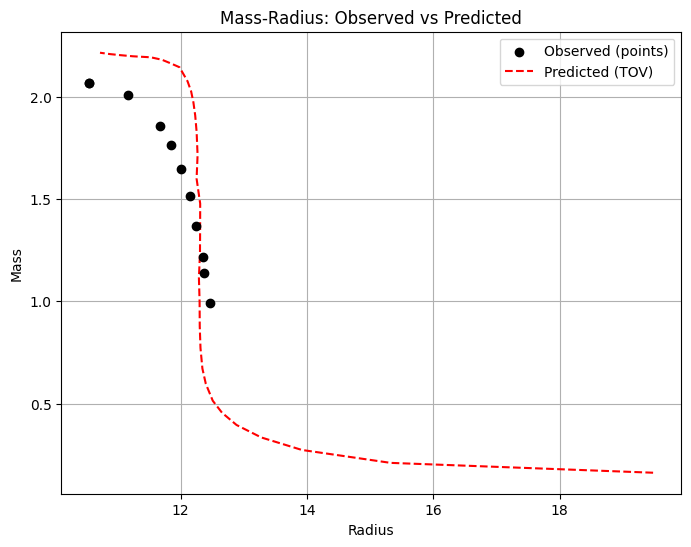

In [57]:
mr_relation_pred = combined_model.predict(X_scaled)

# Inverse-transform predicted M-R back to physical units using mr_scaler
mr_pred_flat = mr_relation_pred.reshape(-1, 2)  # (32, 2)
mr_pred_unscaled = mr_scaler.inverse_transform(mr_pred_flat)
mass_pred = mr_pred_unscaled[:, 0]
radius_pred = mr_pred_unscaled[:, 1]

# Observed M-R (physical units) from obs_df (radius on x-axis)
mass_obs = observed_mr['M'].values
radius_obs = observed_mr['R'].values

# Plot observed and predicted M-R relation
plt.figure(figsize=(8,6))
plt.scatter(radius_obs, mass_obs, color='black', label='Observed (points)', zorder=3)
plt.plot(radius_pred, mass_pred, color='red', linestyle='--', label='Predicted (TOV)', zorder=2)
plt.xlabel('Radius')
plt.ylabel('Mass')
plt.title('Mass-Radius: Observed vs Predicted')
plt.legend()
plt.grid(True)
plt.show()